In [1]:
import glob as gb
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
import matplotlib.mlab as ml
import matplotlib.pyplot as plt

from cycler import cycler
from collections import OrderedDict
from datetime import datetime
from scipy import optimize

%matplotlib notebook

In [2]:
# Save plots?
save = False

In [3]:
def set_colour_map(n):
    # Create colormap for plotting n number of colours
    new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
    plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# Load and plot real time raw data from analysis.h5

In [4]:
# Load HDF file
folder = 'T2_refractive_index_liquids3'
data_folder = '../Data/'
df = pd.HDFStore(data_folder + str(folder) +'/analysis.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

df.head()
# df.info()

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
0,2016-10-11 11:02:12.034481,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,1,400,21.5,21.5,22.47,0.536418,12.447777,-0.018691,0.000000
1,2016-10-11 11:02:12.440521,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,2,400,21.5,21.5,22.47,0.539822,12.447418,-0.018640,0.006767
2,2016-10-11 11:02:12.772554,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,3,400,21.5,21.5,22.47,0.538683,12.448396,-0.018848,0.012301
3,2016-10-11 11:02:12.986576,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,4,400,21.5,21.5,22.47,0.539075,12.444511,-0.018714,0.015868
4,2016-10-11 11:02:13.168594,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,5,400,21.5,21.5,22.47,0.538458,12.448942,-0.018894,0.018902


<IPython.core.display.Javascript object>


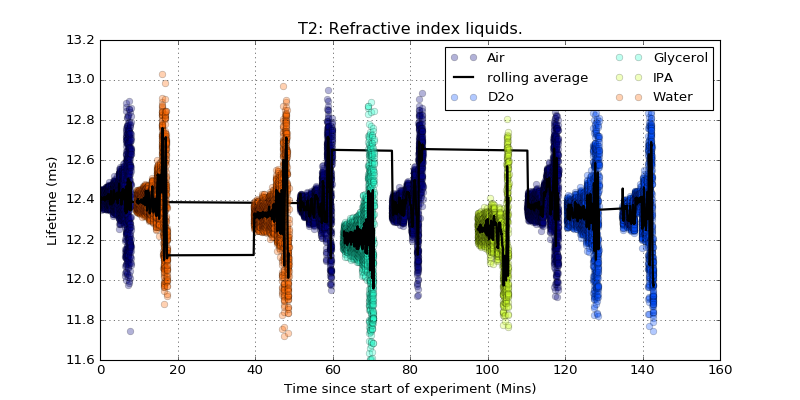

In [5]:
# All in one vs time with moving average
set_colour_map(len(df.medium.unique()))
fig, ax = plt.subplots(figsize=(10,5))
for key, group in df.groupby(['medium']):
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.grid(True, which='major')
ax.set_xlabel('Time since start of experiment (Mins)')
ax.set_ylabel('Lifetime (ms)')
ax.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
# Legend only show rolling mean once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')

if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime_raw.png', dpi=300)

# Drop Data
Drop first water measurement - find corresponding rows to drop

In [6]:
df[(df['medium'] == 'Water') & (df['sweep_no'] == 1) & (df['current'] == 0.5)]

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
2000,2016-10-11 11:11:36.044876,T2,0.5,0.0001,45.13,T2_refractive_index_liquids3,Water,1.33,0.221851,1200,1,400,21.75,21.5,22.39,0.434297,12.344714,-0.018238,9.400173
4000,2016-10-11 11:41:51.472048,T2,0.5,0.0001,44.42,T2_refractive_index_liquids3,Water,1.33,0.223544,1200,1,400,22.25,22.0,22.78,0.406367,12.284894,-0.017880,39.657293


In [7]:
df[(df['medium'] == 'Water') & (df['sweep_no'] == 400) & (df['current'] == 0.1)]

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
3999,2016-10-11 11:19:32.610528,T2,0.1,0.0001,44.94,T2_refractive_index_liquids3,Water,1.33,0.028925,1200,400,400,21.75,21.5,22.40,0.048458,12.366795,-0.017873,17.342934
5999,2016-10-11 11:50:55.162728,T2,0.1,0.0001,44.26,T2_refractive_index_liquids3,Water,1.33,0.028603,1200,400,400,22.25,22.0,22.78,0.045851,12.353501,-0.018609,48.718804


In [8]:
df = df.iloc[np.where((df.index < 2000) | (df.index > 3999))[0]]

Drop unwanted medium

In [9]:
# Drop data (error measurements) - IPA was evaporating 
to_drop = ['D2o']
df = df[~df['medium'].isin(to_drop)]

Replot data in time to check correct data was dropped

<IPython.core.display.Javascript object>


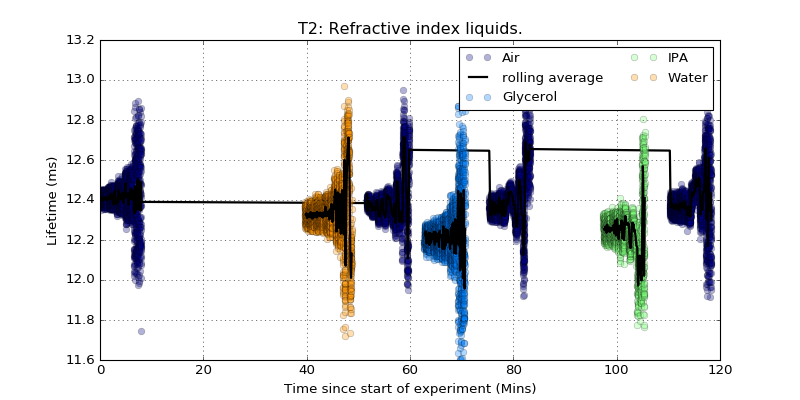

In [10]:
set_colour_map(len(df.medium.unique()))
# All in one vs time with moving average
fig, ax = plt.subplots(figsize=(10,5))
for key, group in df.groupby(['medium']):
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.grid(True, which='major')
ax.set_xlabel('Time since start of experiment (Mins)')
ax.set_ylabel('Lifetime (ms)')
ax.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
# Legend only show rolling mean once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')

if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime_dataCleanup.png', dpi=300)

## Group by current and refractive index and evaluate averate tau & A

In [11]:
# Drop unwanted columns (data not interested in, easier to view)
df = df[['n', 'current', 'tau', 'A', 'medium']]
# Apply mean and std functions to all collumns
g = df.groupby(['current', 'n']).agg([np.mean, np.std]).reset_index()
g.head()

current     n        tau                   A          
                      mean       std      mean       std
0     0.1  1.00  12.458826  0.233409  0.055755  0.003482
1     0.1  1.33  12.356575  0.293052  0.045875  0.000919
2     0.1  1.37  12.169651  0.240522  0.049110  0.000761
3     0.1  1.47  12.238032  0.321725  0.043909  0.001020
4     0.2  1.00  12.404007  0.089143  0.167799  0.008788

<IPython.core.display.Javascript object>


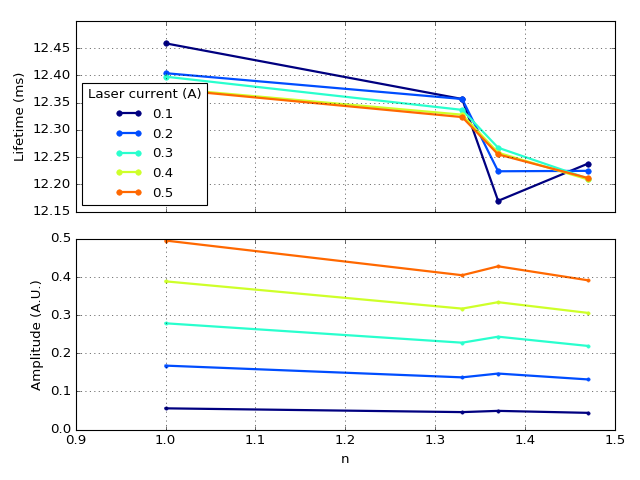

In [14]:
# Two subplots, unpack the axes array immediately
set_colour_map(len(df.current.unique()))
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for key, group in g.groupby('current'):
    ax1.plot(group['n'], group['tau']['mean'], '.-', lw='2', markersize='10', label=key)
    ax2.plot(group['n'], group['A']['mean'], '.-', lw='2', label=key)

ax2.set_xlabel('n')
ax1.set_ylabel('Lifetime (ms)')
ax2.set_ylabel('Amplitude (A.U.)')

ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')
ax1.legend(title='Laser current (A)', loc='best', fontsize='medium')
if save:
    plt.savefig(data_folder +  str(folder) + '/final.png', dpi=300)

<IPython.core.display.Javascript object>


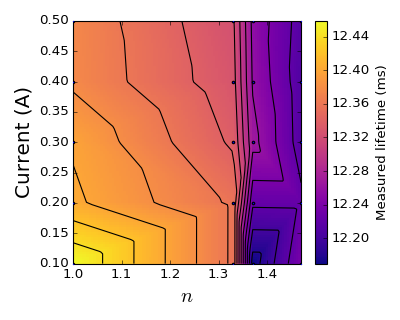

In [15]:
# Contour plot
x = g.n
y = g.current
z = g['tau']['mean']
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
zi = ml.griddata(x, y, z, xi, yi, interp='linear')

fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(111)
plt.contour(xi, yi, zi, 15, linewidths=1, colors='k')
plt.pcolormesh(xi, yi, zi, cmap=plt.get_cmap('plasma'))
cbar = plt.colorbar()
plt.scatter(x, y, marker='o', c='b', s=5, zorder=10)

plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar.ax.set_ylabel('Measured lifetime (ms)', fontsize=12)
ax.set_xlabel('$n$', fontsize=18)
ax.set_ylabel('Current (A)', fontsize=18)
plt.tight_layout()
if save:
    plt.savefig(data_folder +  str(folder) + '/contour_tau.png', dpi=300)

# Decay Rates
### Measured Experimentally

In [37]:
# Calculate decay rate in seconds and add to dataframe 
df['decayRate'] = 1E3/df['tau']

# Group data by current and n and calculate average and std.
data = df.groupby(['current', 'n']).agg([np.mean, np.std]).reset_index()

# OPTIONAL: Select single current -> 0.5 has strongest signal and was first measurement so most reliable
data = data[data['current'] == 0.5].reset_index()
data.head()

index current     n        tau                   A            decayRate  \
                            mean       std      mean       std       mean   
0    16     0.5  1.00  12.375102  0.035660  0.495827  0.025748  80.808086   
1    17     0.5  1.33  12.323421  0.036122  0.404872  0.001584  81.146995   
2    18     0.5  1.37  12.254893  0.039826  0.428246  0.001941  81.600921   
3    19     0.5  1.47  12.211559  0.037988  0.391562  0.001702  81.890420   

             
        std  
0  0.232869  
1  0.237908  
2  0.265195  
3  0.254865

<IPython.core.display.Javascript object>


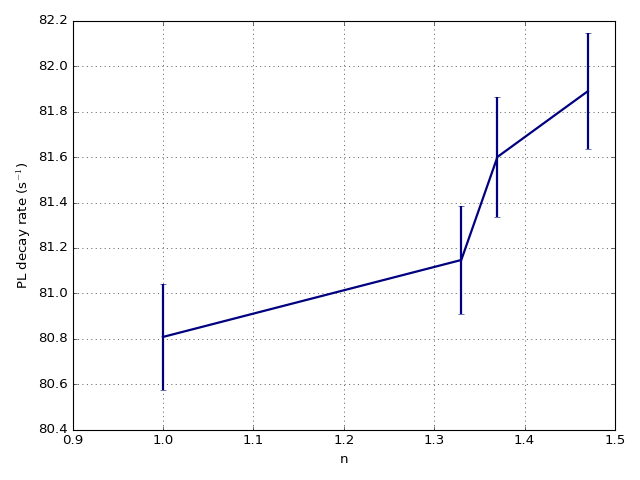

In [43]:
xdata = data['n']
ydata = data['decayRate']['mean']
yerr=data['decayRate']['std']

# PLot n vs decay rate
f, ax = plt.subplots()
ax.errorbar(xdata, ydata, yerr=yerr, label='Experimental', lw=2)
ax.set_xlabel('n')
ax.set_ylabel('PL decay rate (s$^{-1}$)')
ax.grid()
plt.tight_layout()
if save:
    plt.savefig(data_folder +  str(folder) + '/decayRate.png', dpi=300)

### Theoretical decay rates from simulations using chip parameters

<IPython.core.display.Javascript object>


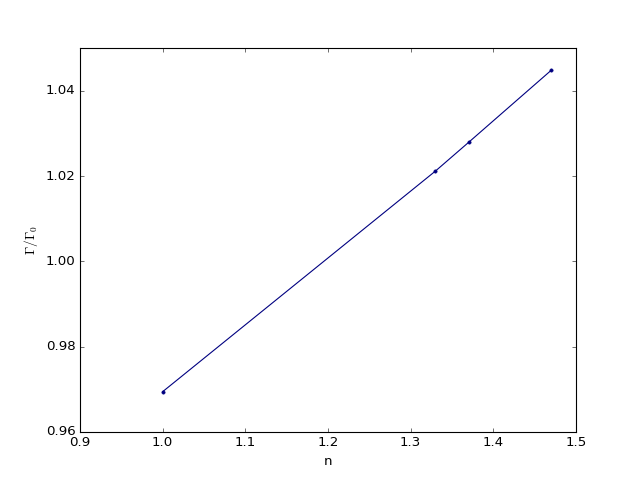

In [48]:
# Load theoretical decay rates vs n and plot
data = np.load(data_folder + 'T2_simulated_decay_Rate/spe_vs_n_t2_nosubstrate.npz')
n = data['n']
fp = data['spe']

# Plot
f, ax = plt.subplots()
ax.plot(n, fp, '.-')
ax.set_xlabel('n')
ax.set_ylabel('$\Gamma / \Gamma_0$')

<IPython.core.display.Javascript object>


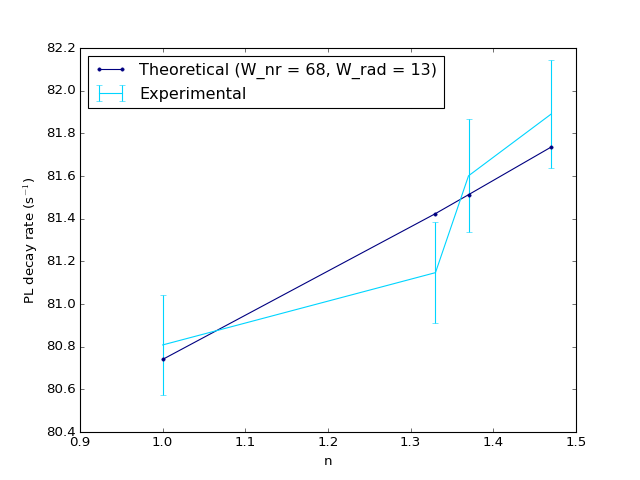

Quantum efficiency is 16.29 %


In [70]:
# REF: http://scipy-cookbook.readthedocs.io/items/FittingData.html
#
# Model for the observed decay rate in terms of non-radiative, radiative
# and average purcell factor (fp) over layer.
#
#  W_tot = W_nr + W_rad * fp(n)
#

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [40, 40]
out = optimize.leastsq(errfunc, pinit,
                       args=(fp, ydata, yerr), full_output=1)

pfinal = out[0]
covar = out[1]

W_nr = pfinal[0]
W_rad = pfinal[1]

set_colour_map(3)
f, ax = plt.subplots()
ax.plot(n, fitfunc(pfinal, fp), '.-', label='Theoretical (W_nr = {0:.2g}, W_rad = {1:.2g})'.format(W_nr, W_rad))
ax.errorbar(xdata, ydata, yerr=yerr, label='Experimental')
ax.set_xlabel('n')
ax.set_ylabel('PL decay rate (s$^{-1}$)')
plt.legend(loc='best')

# Calculate QE from fitted params
QE = lambda W_rad, W_nr: W_rad / (W_rad + W_nr)
print('Quantum efficiency is {:.2f} %'.format(100*QE(W_rad, W_nr)))